<a id="top"></a>
# SpaceX Falcon9 First Stage Landing Prediction
### (Data Analysis)

SpaceX advertises Falcon 9 rocket launches on its website with a cost of 62 million dollars; other providers cost upward of 165 million dollars each, much of the savings is because SpaceX can reuse the first stage. Therefore if we can determine if the first stage will land, we can determine the cost of a launch. This information can be used if an alternate company wants to bid against SpaceX for a rocket launch. In this lab, you will collect and make sure the data is in the correct format from an API. The following is an example of a successful and launch.

## Methodology

Basically I will follow this foundational methodology as the base for this project.

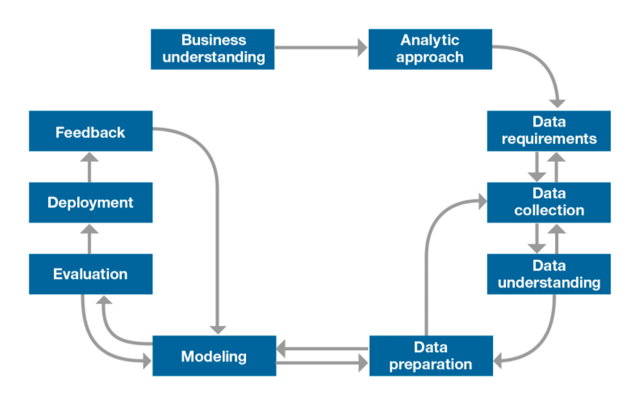

1. Collect data using SpaceX API (HTTP request, JSON) and Save as CSV file.
2. Data Preparation.
    - Data cleaning
    - EDA
    - Feature Engineering
3. Store data in a database (SQlite)
4. Querying data
5. Data Analysis
6. Presentation

<div class="alert alert-info">
    <h4>Table of Content</h4>
    <ol>
        <li>
            <a href="#business-understanding">Business Understanding</a>
            <ol>
                <li><a href="#bu-business-impact">Business Impact</a></li>
                <li><a href="#bu-stackholders">Stackholders</a></li>
                <li><a href="#bu-data-sources">Data Sources</a></li>
                <li><a href="#bu-technology-and-tools">Technology and Tools</a></li>
            </ol>
        </li>
        <li>
            Data Collection
            <ol>
                <li><a href="Data_collection_spacex_api.ipynb">Data Collection - SpaceX API</a></li>
                <li><a href="Data_collection_Webscraping.ipynb">Data Collection - Webscraping (Falcon 9 Wikipedia Page)</a></li>
                <li><a href="Complete_dataset.ipynb">Construct final dataset and persist in a SQLite database.</a></li>
            </ol>
        </li>
        <li>
            <a href="#data-understanding">Data Understanding</a>
        </li>
        <li>
            <a href="#eda">Exploratory Data Analysis</a>
            <ol>
                <li><a href="#eda-datatypes">Explore Data Types</a></li>
                <li><a href="#eda-missingvalues">Dealing with missing values</a></li>
                <li>
                    <a href="#visualization">Data Visualization</a>
                    <ol>
                        <li><a href="#flightno_vs_launchsite">Relationship between Flight Number and Launch Site</a></li>
                        <li><a href="#launchsite_vs_payloadmass">Relationship between Launch Site and Payload Mass</a></li>
                        <li><a href="#flightno_orbit">Relationship between Flight Number and Orbit type</a></li>
                        <li><a href="#payloadmass_orbit">Relationship between Payload Mass and Orbit type</a></li>
                        <li><a href="#success_yearly_trend">Launch Success Yearly Trend</a></li>
                    </ol>
                </li>
                <li>
                    <a href="#location_analysis">Launch Sites Location Analysis (Folium map)</a>
                    <ol>
                        <li><a href="#location_analysis">Locations of all Launch Sites</a></li>
                        <li><a href="#distance">Distance between Launch sites and distance to the closest town</a></li>
                        <li><a href="#success_failure_map">Success and Failures Map</a></li>
                    </ol>
                </li>
            </ol>
        </li>
        <li>
            <a href="#summary">Summary</a>
        </li>
        <li>
            <a href="#">Interactive Dashboard</a>
        </li>
    </ol>
</div>

<a id="business-understanding"></a>
## Business Understanding
<a id="bu-business-impact"></a>
### Business Impact
Aerospace manufacturing is a very expensive process. According to SpaceX website, because of their approach of reusing stage 1 reduces the total cost from a significant amount. Therefore, these analysis and predictions will very useful for future projects of aerospace industry.

<a id="bu-stackholders"></a>
### Stackholders
For this project stackholders possibly be
- SpaceX
- NASA
- Aerospace manufacturers around the world

<a id="bu-data-sources"></a>
### Data Sources
SpaceX API: https://api.spacexdata.com/v4/

From this API, I fetch following data.
<ul>
    <li>Booster Versions</li>
    <li>Launch Site</li>
    <li>Payload Data</li>
    <li>Booster Versions</li>
    <li>Core Data</li>
    <li>Launch Data</li>
</ul>

Falcon 9 Wikipedia Page: 
- Old launches from 2010 - 2019 - https://en.wikipedia.org/wiki/List_of_Falcon_9_and_Falcon_Heavy_launches_(2010%E2%80%932019)
- Latest launches 2020 to present date - https://en.wikipedia.org/wiki/List_of_Falcon_9_and_Falcon_Heavy_launches

<a id="bu-technology-and-tools"></a>
### Technologies and Tools
I have used following tools and technologies for this project.
- **Python statistical libraries and Mathematical libraries** for data analysis
- SQL language
- SQlite
- [Folium](https://python-visualization.github.io/folium/) for interative Maps
- Various **Python libraries** to visualize different insights along the way
- [Plotly Dash](https://dash.plotly.com/) for interactive dashboard

<a class="float-right text-right" href="#top">[Go to Top]</a>

In [1]:
#!pip install sqlalchemy --user
#!pip install geopy --user

<a id="data-understanding"></a>
## Data Understanding
First load the dataset
### Connect to database

In [11]:
# import relevant libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import csv, sqlite3, sqlalchemy

%matplotlib inline

import folium
# Import folium MarkerCluster plugin
from folium.plugins import MarkerCluster
# Import folium MousePosition plugin
from folium.plugins import MousePosition
# Import folium DivIcon plugin
from folium.features import DivIcon

from geopy import distance as geopydist

In [12]:
con = sqlite3.connect("falcon9.db")
cur = con.cursor()

In [13]:
%load_ext sql

The sql extension is already loaded. To reload it, use:
  %reload_ext sql


In [14]:
%sql sqlite:///falcon9.db

#### Create a Pandas Dataframe from SQL query

In [15]:
sql_query = "SELECT * FROM `falcon9_tbl`"

In [16]:
df = pd.read_sql(sql=sql_query, con=con)

In [17]:
df.head()

,Flight_No,Launch_Site,Payload,Payload_Mass,Orbit,Customer,Launch_Outcome,Version_Booster,Booster_Landing,Date,Time,Longitude,Latitude
0,1,CCSFS SLC 40,Dragon Spacecraft Qualification Unit,0.0,LEO,SpaceX,Success,F9 v1.0,Failure,2010-06-04,18:45:00,-80.577366,28.561857
1,2,CCSFS SLC 40,SpaceX COTS Demo Flight 1,0.0,LEO,NASA,Success,F9 v1.0,Failure,2010-12-08,15:43:00,-80.577366,28.561857
2,3,CCSFS SLC 40,SpaceX COTS Demo Flight 2,525.0,LEO,NASA,Success,F9 v1.0,No attempt,2012-05-22,07:44:00,-80.577366,28.561857
3,4,CCSFS SLC 40,SpaceX CRS-1,4700.0,LEO,NASA,Success,F9 v1.0,No attempt,2012-10-08,00:35:00,-80.577366,28.561857
4,5,CCSFS SLC 40,SpaceX CRS-2,4877.0,LEO,NASA,Success,F9 v1.0,No attempt,2013-03-01,15:10:00,-80.577366,28.561857


Before going any further let's add a *class* colum for representing the classification of Booster Landing.

In [18]:
landing_types = df['Booster_Landing'].value_counts()
landing_types

Success         200
No attempt       23
Failure          11
Controlled        6
Uncontrolled      2
Precluded         1
Name: Booster_Landing, dtype: int64

#### Different Types of Booster Landing Status
- **Success** - Successful Landing
- **Failure** - Failed to Land
- **Controlled** and **Uncontrolled** - A controlled "ocean landing" denotes a controlled atmospheric entry, descent and vertical splashdown on the ocean's surface at near zero velocity, for the sole purpose of gathering test data; such boosters were destroyed at sea.
- **Precluded** - Basically the launch failed

We only consider ***Success*** and ***Failure*** Booster Landing in this project. Therefore let's remove unrelevant records from the dataframe.

In [19]:
unrelevant_landing_types = ['No attempt', 'Controlled', 'Uncontrolled', 'Precluded']

In [20]:
# collect indexes to be removed from the dataset
indexes_to_be_deleted = []
for landing_status in unrelevant_landing_types:
    if landing_status in unrelevant_landing_types:
        indexes_to_be_deleted += list(df[df['Booster_Landing'] == landing_status].index)
        
print(indexes_to_be_deleted)

[2, 3, 4, 6, 7, 10, 11, 15, 17, 30, 33, 37, 48, 50, 51, 54, 55, 56, 65, 73, 78, 184, 185, 8, 9, 14, 45, 47, 49, 5, 12, 18]


In [21]:
df.drop(indexes_to_be_deleted, inplace=True)

In [22]:
df['Booster_Landing'].value_counts()

Success    200
Failure     11
Name: Booster_Landing, dtype: int64

Reset *Flight_No* column

In [23]:
df['Flight_No'] = range(1, df.shape[0] + 1)

Before we go beyond, let's add a *Class* variable as the numerical classification dependent variable in the dataset.

In [24]:
df['Class'] = [1 if landing_status == 'Success' else 0 for landing_status in df['Booster_Landing']]

In [25]:
df

,Flight_No,Launch_Site,Payload,Payload_Mass,Orbit,Customer,Launch_Outcome,Version_Booster,Booster_Landing,Date,Time,Longitude,Latitude,Class
0,1,CCSFS SLC 40,Dragon Spacecraft Qualification Unit,0.0,LEO,SpaceX,Success,F9 v1.0,Failure,2010-06-04,18:45:00,-80.577366,28.561857,0
1,2,CCSFS SLC 40,SpaceX COTS Demo Flight 1,0.0,LEO,NASA,Success,F9 v1.0,Failure,2010-12-08,15:43:00,-80.577366,28.561857,0
13,3,CCSFS SLC 40,SpaceX CRS-5,2395.0,LEO,NASA,Success,F9 v1.1,Failure,2015-01-10,09:47:00,-80.577366,28.561857,0
16,4,CCSFS SLC 40,SpaceX CRS-6,1898.0,LEO,NASA,Success,F9 v1.1,Failure,2015-04-14,20:10:00,-80.577366,28.561857,0
19,5,CCSFS SLC 40,Orbcomm-OG2,2034.0,LEO,Orbcomm,Success,F9 FT,Success,2015-12-22,01:29:00,-80.577366,28.561857,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
238,207,CCSFS SLC 40,Starlink Group 5-15,0.0,LEO,SpaceX,Success,F9 B5,Success,2023-07-16,03:50:00,-80.577366,28.561857,1
239,208,VAFB SLC 4E,Starlink Group 6-15,0.0,LEO,SpaceX,Success,F9 B5,Success,2023-07-20,04:09:00,-120.610829,34.632093,1
240,209,CCSFS SLC 40,Starlink Group 6-6,0.0,LEO,SpaceX,Success,F9 B5,Success,2023-07-24,00:50:00,-80.577366,28.561857,1
241,210,CCSFS SLC 40,Starlink Group 6-7,0.0,LEO,SpaceX,Success,F9 B5,Success,2023-07-28,04:01:00,-80.577366,28.561857,1


In [26]:
df['Version_Booster'].unique()

array(['F9 v1.0', 'F9 v1.1', 'F9 FT', 'F9 B4', 'F9 B5'], dtype=object)

In [27]:
df['Class'].value_counts()

1    200
0     11
Name: Class, dtype: int64

There is a long name in *Orbit* coulmn. Let's use the abbreviation of it. Then it will be easy to display in charts and graphs.

In [28]:
df['Orbit'].value_counts()

LEO                               138
GTO                                33
SSO                                21
Polar                               7
MEO                                 6
Ballistic lunar transfer (BLT)      2
HEO                                 1
Heliocentric                        1
Retrograde                          1
Name: Orbit, dtype: int64

In [29]:
df['Orbit'] = df['Orbit'].replace('Ballistic lunar transfer (BLT)', 'BLT')

<a id="eda"></a>
## Exploratory Data Analysis

<a id="eda-datatypes"></a>
#### Explore Data types

In [30]:
df.dtypes

Flight_No            int64
Launch_Site         object
Payload             object
Payload_Mass       float64
Orbit               object
Customer            object
Launch_Outcome      object
Version_Booster     object
Booster_Landing     object
Date                object
Time                object
Longitude          float64
Latitude           float64
Class                int64
dtype: object

<a id="eda-missingvalues"></a>
#### Dealing with missing values

In [31]:
df.isna().sum()

Flight_No          0
Launch_Site        0
Payload            7
Payload_Mass       0
Orbit              1
Customer           0
Launch_Outcome     0
Version_Booster    0
Booster_Landing    0
Date               0
Time               0
Longitude          0
Latitude           0
Class              0
dtype: int64

In [32]:
df['Version_Booster'].unique()

array(['F9 v1.0', 'F9 v1.1', 'F9 FT', 'F9 B4', 'F9 B5'], dtype=object)

<a id="visualization"></a>
### Data Visualization
In this section I explore relationships between different features and try gain insights about how those relationships involve in success/failure landing of Falcon9 first stage.

<a id="flightno_vs_launchsite"></a>
#### Relationship between Flight Number and Launch Site
This *category plot* shows different Launch Sites invlove in each Flight.

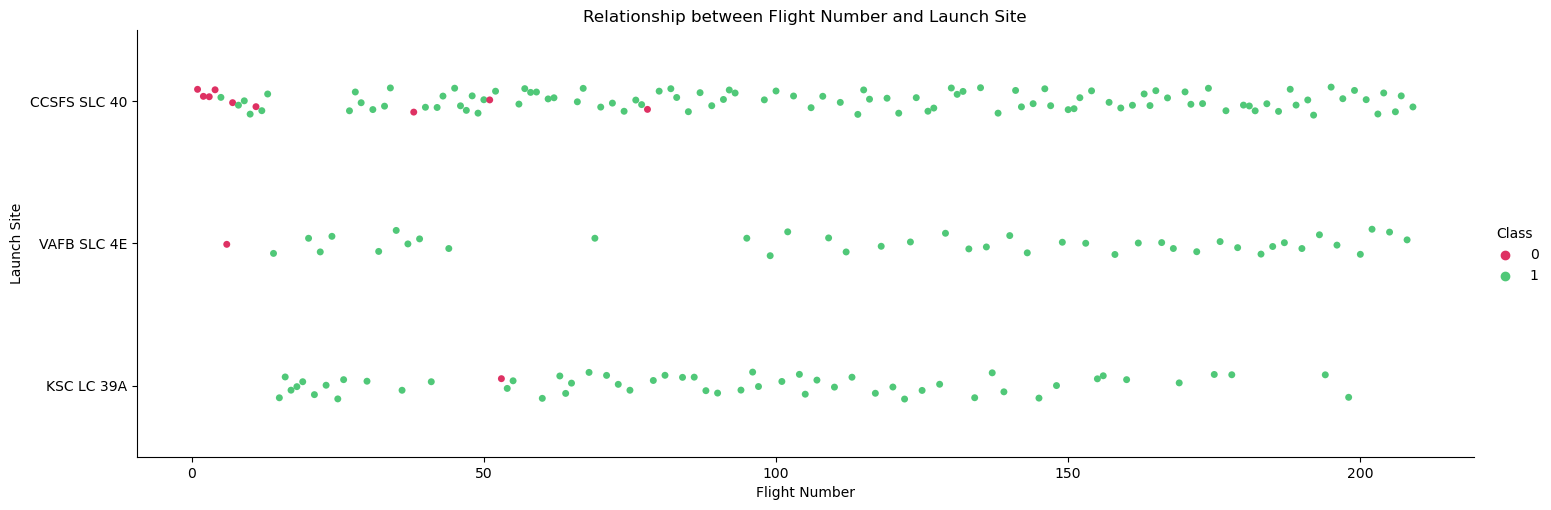

In [23]:
# define my own color palette for binary class
binary_class_palette = sns.set_palette(['#DE3163', '#50C878'])

sns.catplot(data=df, x='Flight_No', y='Launch_Site', hue='Class', aspect=3, palette=binary_class_palette)
plt.title('Relationship between Flight Number and Launch Site')
plt.xlabel('Flight Number')
plt.ylabel('Launch Site')
plt.show()

<div class="alert alert-info">
    <h4>Observations:</h4>
    <ol>
        <li><b>CCSFS SLC 40</b> has been used quite a lot consistantly and was the first one to be used.</li>
        <li>Booster landings on all three Launch Sites has improved significantly after around 80 Flights.</li>
    </ol>
</div>

<a id="launchsite_vs_payloadmass"></a>
#### Relationship between Launch Site and Payload Mass
This *Category plot* shows how much of Payload Mass had been carried by the rocket boosters launched from each Launch Sites and how this relationship influences in success rate.

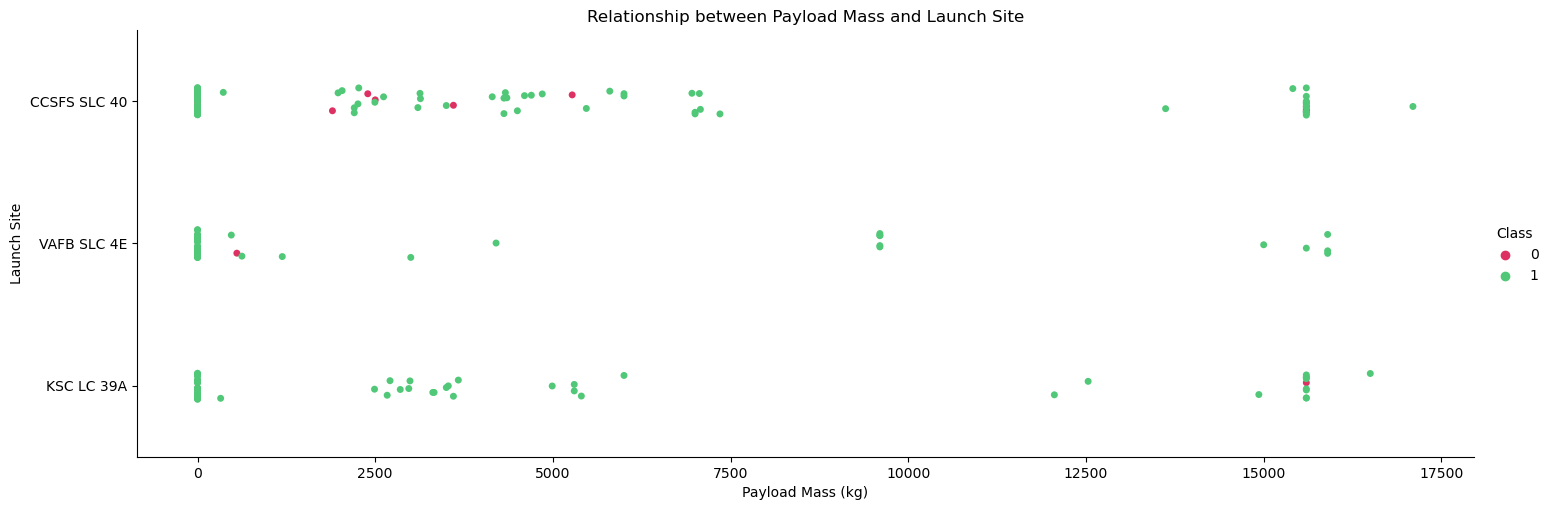

In [24]:
sns.catplot(data=df, x='Payload_Mass', y='Launch_Site', hue='Class', aspect=3, palette=binary_class_palette)
plt.title('Relationship between Payload Mass and Launch Site')
plt.xlabel('Payload Mass (kg)')
plt.ylabel('Launch Site')
plt.show()

<div class="alert alert-info">
    <h4>Observations:</h4>
    <ol>
        <li>Launch sites <b>CCSFS SLC 40</b> and <b>KSC LC 29A</b> have been used for launches with many different payload mass.</li>
        <li>Payload mass between around 2000kg and 7500kg is the usual values for majority of the launches.</li>
    </ol>
</div>

<a id="flightno_orbit"></a>
#### Relationship between Flight Number and Orbit type
Following sub plots shows how many launches had been aimed for different [Orbit type](https://www.esa.int/Enabling_Support/Space_Transportation/Types_of_orbits) and it's influence for success/failure landing.

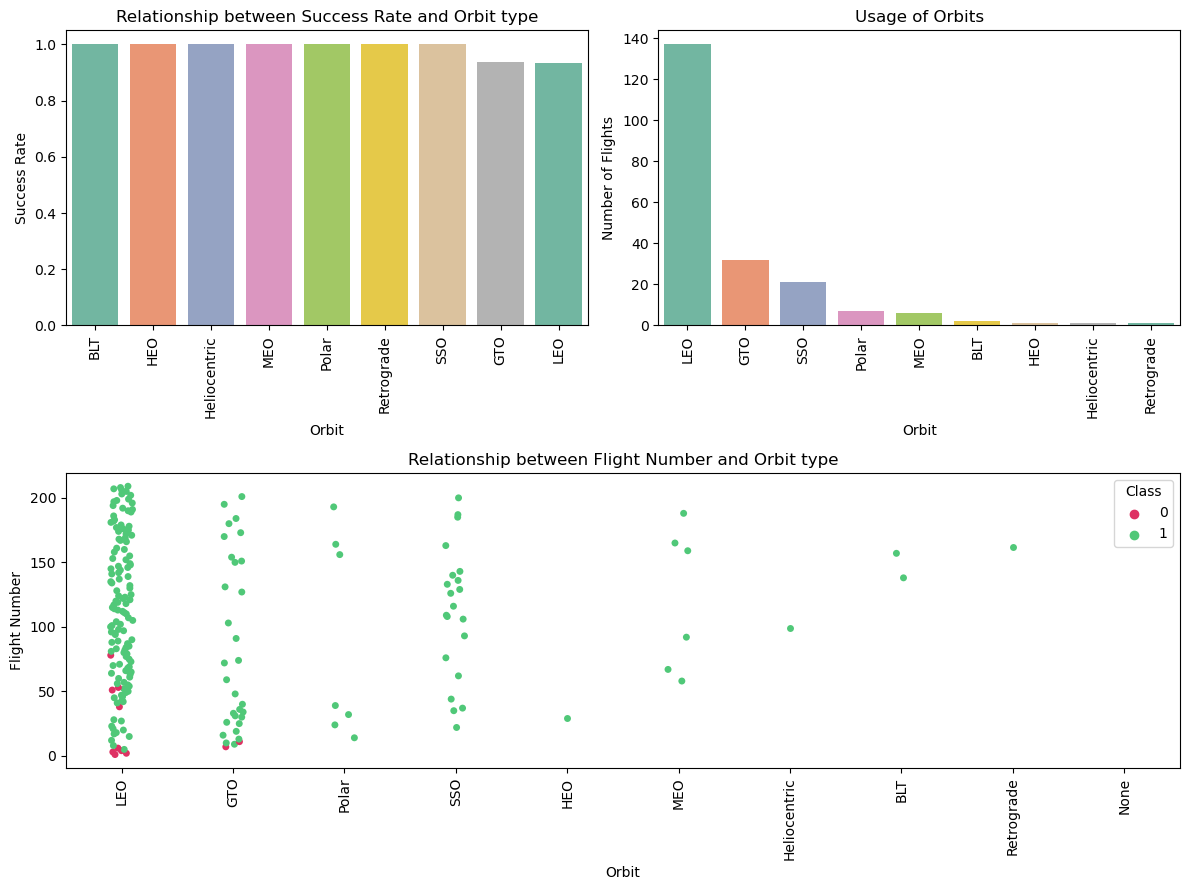

In [49]:
usage_of_orbits = df['Orbit'].value_counts()
usage_of_orbits = usage_of_orbits.to_frame(name='no_of_flights').reset_index(names=['Orbit_type'])

plt.figure(figsize=(12, 9))
ax1 = plt.subplot(2, 1, 2)
sns.stripplot(data=df, x='Orbit', y='Flight_No', hue='Class', palette=binary_class_palette ,ax=ax1)
plt.title('Relationship between Flight Number and Orbit type')
plt.xlabel('Orbit')
plt.ylabel('Flight Number')
plt.xticks(rotation=90)

ax2 = plt.subplot(2, 2, 1)
success_rate_orbit_type = df[['Orbit', 'Class']].groupby('Orbit').mean().reset_index().sort_values(by='Class', ascending=False)
#success_rate_orbit_type
#plt.figure(figsize=(8, 3))
sns.barplot(data=success_rate_orbit_type, x="Orbit", y="Class", palette='Set2', ax=ax2)
plt.title('Relationship between Success Rate and Orbit type')
plt.xlabel("Orbit")
plt.ylabel("Success Rate")
plt.xticks(rotation=90)

#plt.figure(figsize=(10, 5))
ax3 = plt.subplot(2, 2, 2)
sns.barplot(data=usage_of_orbits, x='Orbit_type', y='no_of_flights', palette='Set2', ax=ax3)
plt.title('Usage of Orbits')
plt.xlabel('Orbit')
plt.ylabel('Number of Flights')
plt.xticks(rotation=90)

plt.tight_layout()
plt.show()

<div class="alert alert-info">
    <h4>Observations:</h4>
    <ol>
        <li>Top two bar charts shows how offten each orbit has been aimed and their respective success rates.</li>
        <li><b>BLT</b>, <b>HEO</b>, <b>Heliocentric</b>, <b>MEO</b>, <b>Polar</b>, <b>Retrograde</b>, and <b>SSO</b> have 100% success rate. (High Earth Orbits, rarely used Orbits)</li> 
        <li><b>GTO</b>, and <b>LEO</b> have little less but over 95% of success rate. (Low Earth Orbits, Frequently used Orbits mainly for cargo transportation.)</li> 
    </ol>
</div>

<a id="payloadmass_orbit"></a>
#### Relationship between Payload Mass and Orbit type
This graph shows how different weights of Payloads transported to different Orbits impacted on success landing rate.

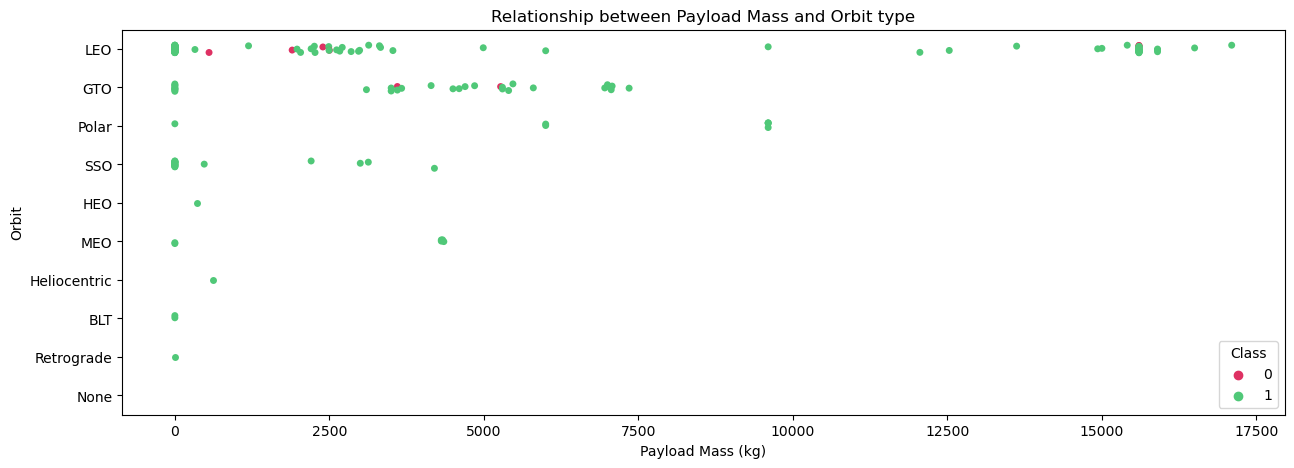

In [27]:
plt.figure(figsize=(15, 5))
sns.stripplot(data=df, x='Payload_Mass', y='Orbit', hue='Class', palette=binary_class_palette)
plt.title('Relationship between Payload Mass and Orbit type')
plt.xlabel('Payload Mass (kg)')
plt.ylabel('Orbit')
plt.show()

<a id="success_yearly_trend"></a>
#### Launch Success Yearly Trend
This graph shows how the launch success rate has grawn over the years.

In [28]:
# separate Year from Date
import datetime

df['Year'] = pd.to_datetime(df['Date']).dt.year
df.head()

,Flight_No,Launch_Site,Payload,Payload_Mass,Orbit,Customer,Launch_Outcome,Version_Booster,Booster_Landing,Date,Time,Longitude,Latitude,Class,Year
0,1,CCSFS SLC 40,Dragon Spacecraft Qualification Unit,0.0,LEO,SpaceX,Success,F9 v1.0,Failure,2010-06-04,18:45:00,-80.577366,28.561857,0,2010
1,2,CCSFS SLC 40,SpaceX COTS Demo Flight 1,0.0,LEO,NASA,Success,F9 v1.0,Failure,2010-12-08,15:43:00,-80.577366,28.561857,0,2010
13,3,CCSFS SLC 40,SpaceX CRS-5,2395.0,LEO,NASA,Success,F9 v1.1B1012,Failure,2015-01-10,09:47:00,-80.577366,28.561857,0,2015
16,4,CCSFS SLC 40,SpaceX CRS-6,1898.0,LEO,NASA,Success,F9 v1.1B1015,Failure,2015-04-14,20:10:00,-80.577366,28.561857,0,2015
19,5,CCSFS SLC 40,Orbcomm-OG2,2034.0,LEO,Orbcomm,Success,F9 FTB1019,Success,2015-12-22,01:29:00,-80.577366,28.561857,1,2015


In [29]:
df['Year'].value_counts()

2022    58
2023    47
2021    31
2020    25
2017    14
2018    11
2019    10
2016     8
2015     3
2010     2
Name: Year, dtype: int64

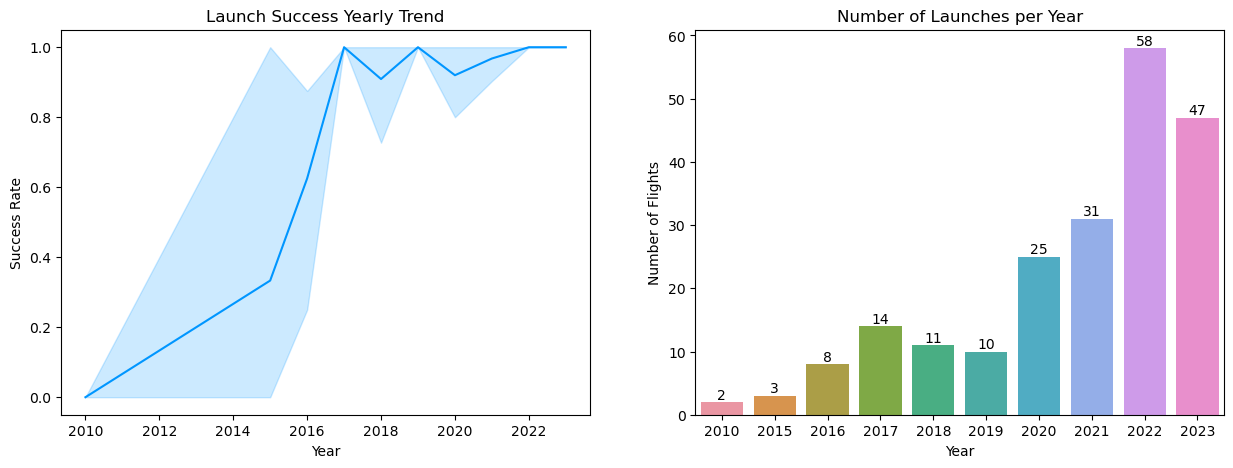

In [30]:
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
sns.lineplot(data=df, x='Year', y='Class', color='#0096FF')
plt.title('Launch Success Yearly Trend')
plt.ylabel('Success Rate')

ax1 = plt.subplot(1, 2, 2)
sns.countplot(data=df, x='Year', ax=ax1)
plt.title('Number of Launches per Year')
plt.ylabel('Number of Flights')
plt.bar_label(ax1.containers[0], label_type='edge')
plt.show()

<div class="alert alert-info">
    <h4>Observations:</h4>
    <ol>
        <li>Slow increment of success rate from year <b>2010</b> to <b>2015</b>.</li>
        <li>After year <b>2015</b> there is a steep rise until 2017. In <b>2017</b> it reaches 100% success rate and then maintain an overall stability above 90%.</li>
        <li>This trend clearly leads to <b>100% stable success rate</b> very soon.</li>
    </ol>
</div>

<a id="location_analysis"></a>
### Launch Sites Location Analysis (Folium map)
In this section I'm using location data of launch sites to find some insights about the success rate and the geometric location.
#### Locations of all Launch Sites

In [31]:
df[['Launch_Site', 'Latitude', 'Longitude']].groupby('Launch_Site').first()

,Latitude,Longitude
Launch_Site,,
CCSFS SLC 40,28.561857,-80.577366
KSC LC 39A,28.608058,-80.603956
VAFB SLC 4E,34.632093,-120.610829


<a id="distance"></a>
#### Distance between Launch sites and distance to the closest town.

In [32]:
ccsfs_loc = (28.561857, -80.577366)
kcs_loc = (28.608058, -80.603956)
vafb_loc = (34.632093, -120.610829)

distance_ccsfs_kcs = geopydist.distance(ccsfs_loc, kcs_loc).km
distance_ccsfs_vafb = geopydist.distance(ccsfs_loc, vafb_loc).km
distance_kcs_vafb = geopydist.distance(kcs_loc, vafb_loc).km

print('-Distance between Launch Sites-')
print("Distance between CCSFS SLC 40 and KSC LC 39A - %dkm" % distance_ccsfs_kcs)
print("Distance between CCSFS SLC 40 and VAFB SLC 4E - %dkm" % distance_ccsfs_vafb)
print("Distance between KSC LC 39A 40 and VAFB SLC 4E - %dkm" % distance_kcs_vafb)

distance_ccsfs_closest_town = geopydist.distance(ccsfs_loc, (28.61218, -80.80796)).km
distance_kcs_closest_town = geopydist.distance(kcs_loc, (28.61218, -80.80796)).km
distance_vafb_closest_town = geopydist.distance(vafb_loc, (34.6533, -120.4629)).km

print('\n-Distance to the closest town from Launch Sites-')
print("Distance between CCSFS SLC 40 and closest town (Titusville) - %dkm" % distance_ccsfs_closest_town)
print("Distance between KSC LC 39A 40 and closest town (Titusville) - %dkm" % distance_kcs_closest_town)
print("Distance between VAFB SLC 4E and closest town (Lompoc) - %dkm" % distance_vafb_closest_town)

-Distance between Launch Sites-
Distance between CCSFS SLC 40 and KSC LC 39A - 5km
Distance between CCSFS SLC 40 and VAFB SLC 4E - 3833km
Distance between KSC LC 39A 40 and VAFB SLC 4E - 3828km

-Distance to the closest town from Launch Sites-
Distance between CCSFS SLC 40 and closest town (Titusville) - 23km
Distance between KSC LC 39A 40 and closest town (Titusville) - 19km
Distance between VAFB SLC 4E and closest town (Lompoc) - 13km


<div class='alert alert-info'>
    Launch site <b>VAFB SLC 4E</b> is located ~3830km away from <b>KSC LC 39A</b> and <b>CCSFS SLC</b>.<br />
    <b>KSC LC 39A</b> and <b>CCSFS SLC</b> are located very closely as ~5km away from each other.
</div>

#### Geographical Map is the best way to analyse location data
I'm using *Folium* library for this project. <br/>
I have marked following things on the map.
- Locations of launch sites
- Distance between each launch sites
- Diatance from Launch Site to closest town
- Success/Failure landings

In [33]:
# helper function for Maps
def distanceMarker(origin_coordinates, proximity_data, map_obj, marker_color='#0096FF', text_marker_adjust=[0, 0]):
    """distanceMarker function draws a line between two points and mark the distance in km.
    
    Inputs: 
    1. origin_coordinates - [Latitude, Longitude] of origin location.
    2. proximity_data - Two dimentional array with proximity measurements.
    ex:
    proximity_data = [
        [coastline_lat, coastline_lon],
        [railway_lat, railway_lon],
        [highway_lat, highway_lon]
    ]
        
    3. map_obj - Folium Map object
    4. marker_color - Hexadecimal color code for marker and line. Default - #0096FF
    
    Output: 
    Updated Folium Map object
    
    """
    
    for prox in proximity_data:
        #print(prox[0], prox[1])
        distance = geopydist.distance((origin_coordinates[0], origin_coordinates[1]), (prox[0], prox[1])).km
        destination_lat = prox[0]
        destination_lon = prox[1]
    
    folium.Marker(
       [destination_lat, destination_lon],
       icon=DivIcon(
           icon_size=(20,20),
           icon_anchor=(-5 + text_marker_adjust[0], 20 + text_marker_adjust[1]),
           html='<div style="font-size: 14px; color:%s; width: 100px;"><b>%s</b></div>' % (marker_color, "{:10.2f} km".format(distance)),
           )
       ).add_to(map_obj)
    
    coordinates = [(origin_coordinates[0], origin_coordinates[1]), (destination_lat, destination_lon)]
    folium.PolyLine(locations=coordinates, weight=2, color=marker_color).add_to(map_obj)
        
    return map_obj


#### Distance map

In [34]:
# initialize the map
center_location = [29.15216, -98.52539]
site_map = folium.Map(location=center_location, zoom_start=5)

# add launch site location markers on the map
for site_name, lat, lon in zip(df['Launch_Site'], df['Latitude'], df['Longitude']):
    site_location = [lat, lon]
    
    # draw 1km radious circles around launch sites and mark it on the map
    folium.Circle(
        location=site_location, 
        radius=1000, 
        popup=folium.Popup(site_name), 
        color='#DC143C', 
        fill=False).add_to(site_map)
    
    folium.map.Marker(
        location=site_location, 
        icon=DivIcon(
            icon_size=(20,20), 
            icon_anchor=(0,0), 
            html='<div style="font-size: 18px; color:#DC143C;  width: 150px;"><b>%s</b></div>' % site_name)
    ).add_to(site_map)
    
    # distance between launch sites
    ccsfs_coords = [28.561857, -80.577366]
    kcs_coords = [28.608058, -80.603956]
    vafb_coords = [34.632093, -120.610829]
    
    # draw a line and mark distances between launch sites
    # VAFB ----> KCS
    proximity_data_vafb_kcs = [
        [kcs_coords[0], kcs_coords[1]]
    ]
    site_map = distanceMarker(vafb_coords, proximity_data_vafb_kcs, site_map, '#088F8F')
    
    # VAFB ----> CCSFS
    proximity_data_vafb_ccsfs = [
        [ccsfs_coords[0], ccsfs_coords[1]]
    ]
    site_map = distanceMarker(vafb_coords, proximity_data_vafb_ccsfs, site_map, '#3F00FF')
    
    # CCSFS ----> KCS
    proximity_data_from_ccsfs = [
        [ccsfs_coords[0], ccsfs_coords[1]]
    ]
    site_map = distanceMarker(kcs_coords, proximity_data_from_ccsfs, site_map, text_marker_adjust=[15, 15])
    
    # distance to the closest town from launch sites
    # CCSFS to Titusville
    titusville_coords = [28.61218, -80.80796]
    proximity_data_from_ccsfs_to_titusville = [
        [titusville_coords[0], titusville_coords[1]]
    ]
    site_map = distanceMarker(ccsfs_coords, proximity_data_from_ccsfs_to_titusville, site_map, '#FF5733', text_marker_adjust=[0, -25])
    
    # KCS to Tutusville
    proximity_data_from_kcs_to_titusville = [
        [titusville_coords[0], titusville_coords[1]]
    ]
    site_map = distanceMarker(kcs_coords, proximity_data_from_kcs_to_titusville, site_map, '#C70039', text_marker_adjust=[5, 5])
        
site_map    

<a id="success_failure_map"></a>
#### Success and Failures on the Map
I separate different launch site events into "Clusters". Folium clusters are really helpful to group large number of events together.

Click on each clusters to expand them.

In [35]:
spacex_df = df[['Launch_Site', 'Latitude', 'Longitude', 'Class']]
spacex_df

,Launch_Site,Latitude,Longitude,Class
0,CCSFS SLC 40,28.561857,-80.577366,0
1,CCSFS SLC 40,28.561857,-80.577366,0
13,CCSFS SLC 40,28.561857,-80.577366,0
16,CCSFS SLC 40,28.561857,-80.577366,0
19,CCSFS SLC 40,28.561857,-80.577366,1
...,...,...,...,...
236,VAFB SLC 4E,34.632093,-120.610829,1
237,CCSFS SLC 40,28.561857,-80.577366,1
238,CCSFS SLC 40,28.561857,-80.577366,1
239,VAFB SLC 4E,34.632093,-120.610829,1


In [36]:
# Apply a function to check the value of `class` column
# If class=1, marker_color value will be green
# If class=0, marker_color value will be red
def applyColor(class_value):
    colors = ['red', 'green']
    return colors[class_value]
    
    
spacex_df['marker_color'] = list(map(applyColor, spacex_df['Class']))
spacex_df

C:\Users\navilog\AppData\Local\Temp\ipykernel_24024\2735960165.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  spacex_df['marker_color'] = list(map(applyColor, spacex_df['Class']))


,Launch_Site,Latitude,Longitude,Class,marker_color
0,CCSFS SLC 40,28.561857,-80.577366,0,red
1,CCSFS SLC 40,28.561857,-80.577366,0,red
13,CCSFS SLC 40,28.561857,-80.577366,0,red
16,CCSFS SLC 40,28.561857,-80.577366,0,red
19,CCSFS SLC 40,28.561857,-80.577366,1,green
...,...,...,...,...,...
236,VAFB SLC 4E,34.632093,-120.610829,1,green
237,CCSFS SLC 40,28.561857,-80.577366,1,green
238,CCSFS SLC 40,28.561857,-80.577366,1,green
239,VAFB SLC 4E,34.632093,-120.610829,1,green


In [37]:
marker_cluster = MarkerCluster()

# Add marker_cluster to current site_map
site_map2 = folium.Map(location=center_location, zoom_start=5)

# add launch site location markers on the map
for site_name, lat, lon in zip(spacex_df['Launch_Site'], spacex_df['Latitude'], spacex_df['Longitude']):
    site_location = [lat, lon]
    
    # draw 1km radious circles around launch sites and mark it on the map
    folium.Circle(
        location=site_location, 
        radius=1000, 
        popup=folium.Popup(site_name), 
        color='#DC143C', 
        fill=False).add_to(site_map2)
    
    folium.map.Marker(
        location=site_location, 
        icon=DivIcon(
            icon_size=(20,20), 
            icon_anchor=(0,0), 
            html='<div style="font-size: 18px; color:#DC143C;  width: 150px;"><b>%s</b></div>' % site_name)
    ).add_to(site_map2)
    
site_map2.add_child(marker_cluster)

for index, record in spacex_df.iterrows():  
    # add a Marker cluster to the site map
    icon_ = folium.map.Icon(color=record.marker_color, icon='rocket', prefix='fa')
    marker = folium.Marker(
        location=[record.Latitude, record.Longitude],
        icon=icon_,
        popup=record['Launch_Site'])
    marker_cluster.add_child(marker)

site_map2

<a id="summary"></a>
## Summary
In this project I have implemented processes for
1. collecting data from different sources
2. collecting, data wrangling and storing data in a database
3. retrieve data from database using SQL 
4. EDA
5. Interactive maps using Folium

Now we can perform Feature Engineering and Model building process.

-- End of the Project --